### Temporal Differencing

In [1]:
import os
import time
import gymnasium as gym
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns
from tqdm import tqdm, trange

from collections import defaultdict
from IPython.display import clear_output, display

C:\Users\duasp\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Some Basic Directories for housekeeping
# set location of input files:
inpDir = os.path.join( '..', 'input')

outDir = os.path.join('..', 'output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results
SMALL_ENOUGH = 1e-3
GAMMA = 0.90    # 0.99
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')
EPISODES = 500000
ALPHA = 0.1

CMAP = plt.cm.rainbow
plt.set_cmap(CMAP);
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

# Define constants for data manipulation
TEST_SIZE = 0.2
NOISE = 0.2
N_SAMPLE = 1024

<Figure size 640x480 with 0 Axes>

In [3]:
# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',    
          'figure.figsize': (12, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large',
          'savefig.dpi': 75,
          'image.cmap': 'summer',
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }


plt.rcParams.update(params)

'''plt.rc('axes', prop_cycle=(
    cycler('color', mglearn.plot_helpers.cm_cycle.colors) +
    cycler('linestyle', ['-', '-', "--", (0, (3, 3)), (0, (1.5, 1.5))])))
'''
np.set_printoptions(precision=3, suppress=True)

pd.set_option("display.max_columns", 8)
pd.set_option('display.precision', 2)

__all__ = ['np', 'display', 'plt', 'pd', 'sklearn', 'seaborn']

### frozen Lake -v1

In [4]:
action_mapping = {
    0: '\u2190',    #Left
    1:'\u2193',     #Down
    2:'\u2192',    #right
    3:'\u2191',    #Up
}
print(action_mapping)

{0: '←', 1: '↓', 2: '→', 3: '↑'}


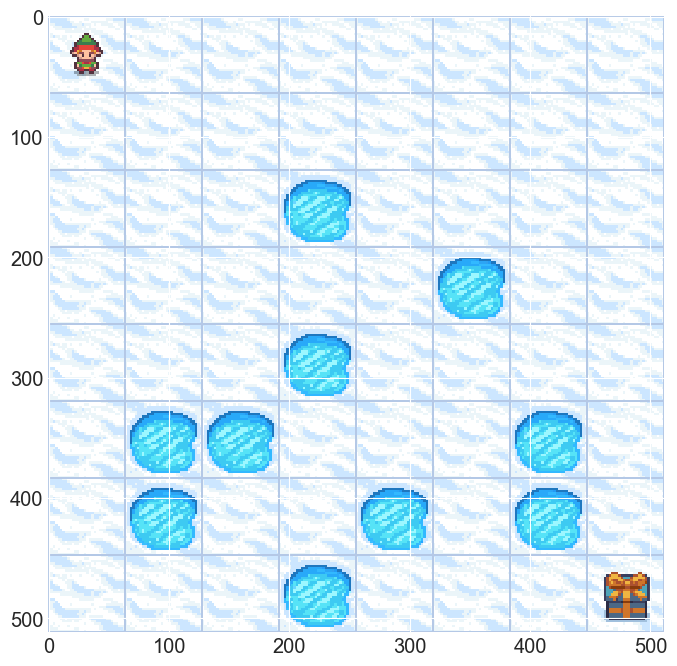

In [5]:
env  =gym.make('FrozenLake-v1',
               map_name = '8x8',
               render_mode='rgb_array',
               is_slippery=True)

env.reset(seed=RANDOM_STATE)

img=plt.imshow(env.render())

0 0.0 False False {'prob': 0.3333333333333333}


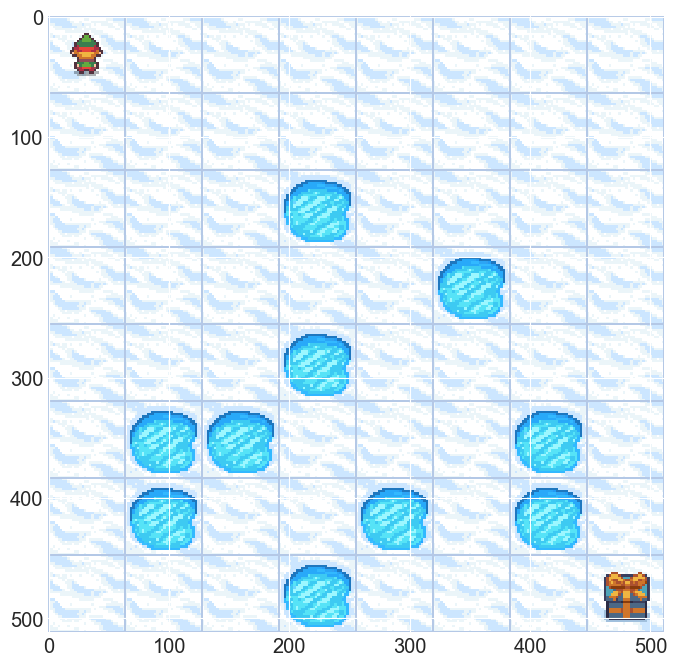

In [6]:
env.reset()
action = 3
#env.step(action)
observation, reward, terminated, truncated, prob = env.step(action)

img  = plt.imshow(env.render())

print(observation, reward, terminated, truncated, prob)

In [7]:
env.reset()

(0, {'prob': 1})

In [8]:
env.step(1)

(8, 0.0, False, False, {'prob': 0.3333333333333333})

In [9]:
env.action_space.sample()

3

### Generate Episodes

In [10]:
def fn_generate_episodes(env):
    '''
    Args:
        env: Gymnasium Envirnment
        
    Return:
        list of states actions and rewards
    '''
    states, actions, rewards = [], [], []
    
    observation = env.reset()[0]
    
    while True:
        states.append(observation)
        action = env.action_space.sample()
        actions.append(action)
        
        #Take that action
        observation, reward, terminated, truncated, info  =env.step(action)
        rewards.append(reward)
        
        done = terminated or truncated
        
        if done:
            break  
    return states, actions, rewards 

In [11]:
states, actions, rewards = fn_generate_episodes(env)

print(f'states:{states}\nActions:{actions}\nRewards:{rewards}')

states:[0, 8, 16, 24, 32, 24, 24, 16, 24, 32, 33, 34]
Actions:[0, 2, 0, 0, 2, 0, 2, 2, 0, 2, 3, 3]
Rewards:[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


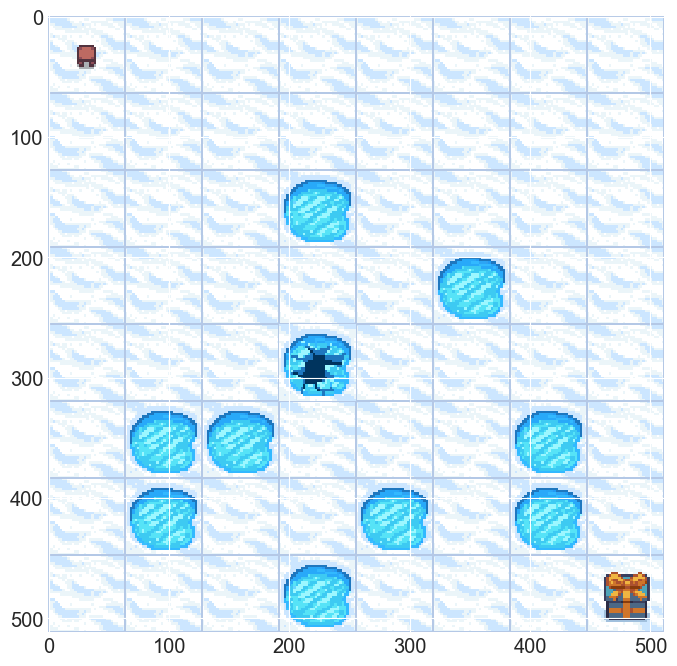

In [12]:
for i in actions:
    observation, reward, terminated, truncated, info  =env.step(i)
    img  = plt.imshow(env.render())

In [13]:
def fn_td_prediction(env, n_episodes = EPISODES):
    value_table = np.random.rand(env.observation_space.n) * (-0.1)

    for _ in trange(n_episodes):
        
        states, _, rewards = fn_generate_episodes(env)
      
        for t in range(len(states)-1):
            reward = rewards[t+1]
            next_state = states[t+1]
            cur_state = states[t]
            value_table[cur_state] = (value_table[cur_state] + ALPHA *(reward + GAMMA * value_table[next_state] - value_table[cur_state]))  
    return value_table

In [15]:
value = fn_td_prediction(env)

100%|████████████████████████████████████████████████████████████████████████| 500000/500000 [04:14<00:00, 1964.14it/s]


In [16]:
def fn_get_optimal_policy(grid, V):
    policy = np.zeros((grid.observation_space.n, grid.action_space.n))
    
    for state in range(grid.observation_space.n):
        action_values = np.zeros((grid.action_space.n))
        
        for action in range(grid.action_space.n):
            for probability, next_state, reward, terminated in grid.unwrapped.P[state][action]:
                action_values[action] += probability *(reward + GAMMA *V[next_state])
        best_action = np.argmax(action_values)
        policy[state][best_action] = 1.0
    return policy      

In [17]:
policy = fn_get_optimal_policy(env, value)
policy

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],


In [18]:
value.shape

(64,)

In [23]:
plot_grid = value.reshape(8,8)

plot_grid

array([[ 0.001,  0.001,  0.002,  0.003,  0.006,  0.008,  0.011,  0.014],
       [ 0.001,  0.001,  0.002,  0.003,  0.01 ,  0.014,  0.02 ,  0.022],
       [ 0.001,  0.001,  0.002, -0.089,  0.013,  0.018,  0.038,  0.048],
       [ 0.001,  0.002,  0.003,  0.014,  0.022, -0.023,  0.069,  0.081],
       [ 0.001,  0.002,  0.003, -0.05 ,  0.05 ,  0.07 ,  0.096,  0.199],
       [ 0.001, -0.062, -0.014,  0.033,  0.054,  0.086, -0.094,  0.42 ],
       [ 0.001, -0.1  ,  0.011,  0.018, -0.097,  0.183, -0.07 ,  0.776],
       [ 0.002,  0.004,  0.006, -0.035,  0.266,  0.262,  0.48 , -0.003]])

<Axes: >

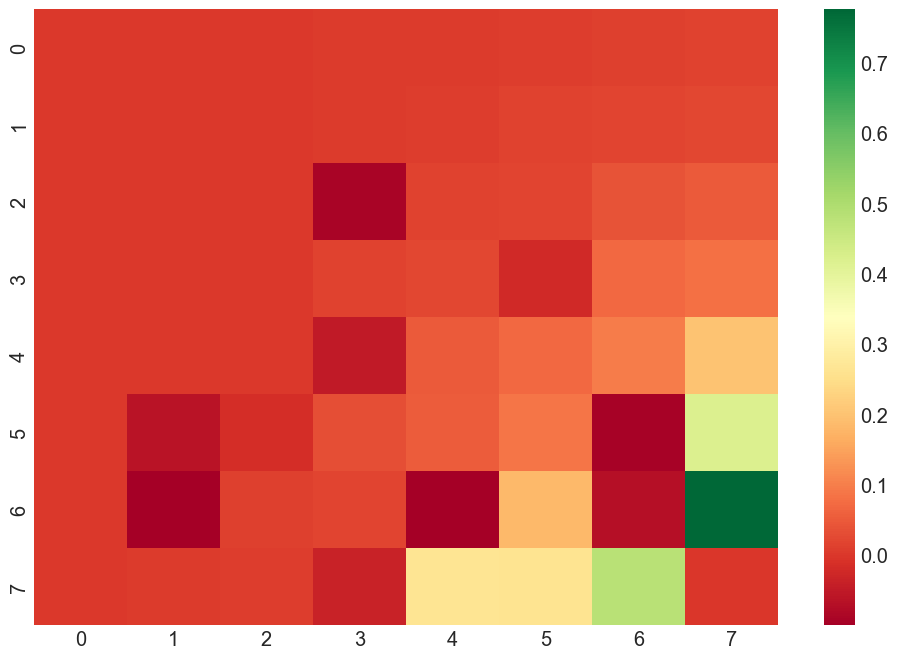

In [24]:
sns.heatmap(plot_grid, cmap = 'RdYlGn')

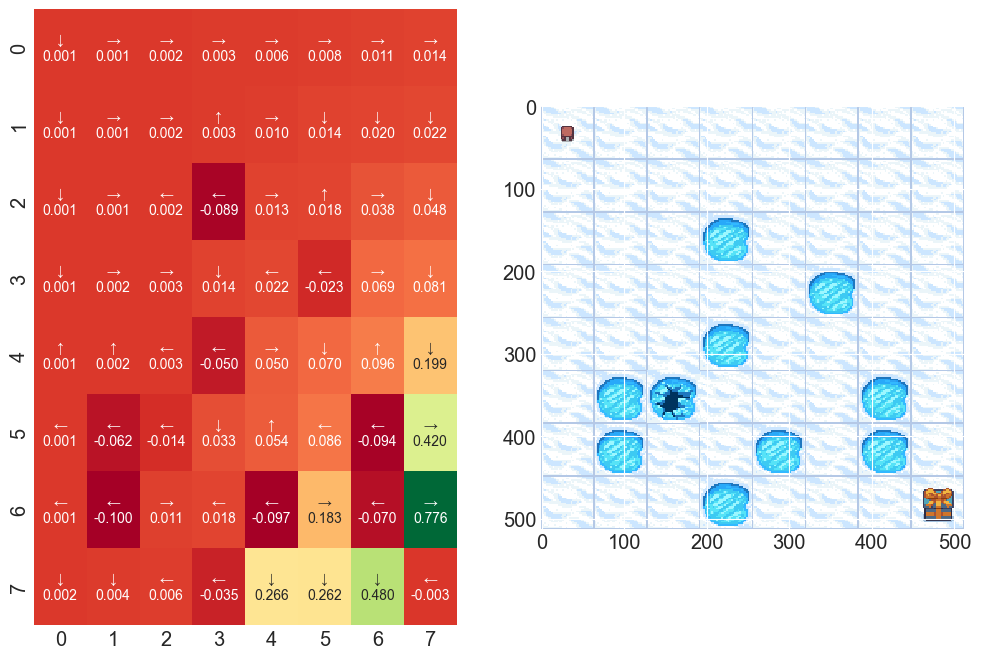

In [25]:
fig, axes = plt.subplots(1,2)

act = [action_mapping[action] for action in np.argmax(policy, axis = 1)]

labels = np.asarray([f'{a}\n{v:.3f}'
                     for a, v in zip(act, plot_grid.ravel())]).reshape(8,8)

sns.heatmap(plot_grid, annot = labels,
            fmt = '', cmap = 'RdYlGn',
            ax = axes[0], cbar = False)
axes[1].imshow(env.render());

In [26]:
labels

array([['↓\n0.001', '→\n0.001', '→\n0.002', '→\n0.003', '→\n0.006',
        '→\n0.008', '→\n0.011', '→\n0.014'],
       ['↓\n0.001', '→\n0.001', '→\n0.002', '↑\n0.003', '→\n0.010',
        '↓\n0.014', '↓\n0.020', '↓\n0.022'],
       ['↓\n0.001', '→\n0.001', '←\n0.002', '←\n-0.089', '→\n0.013',
        '↑\n0.018', '→\n0.038', '↓\n0.048'],
       ['↓\n0.001', '→\n0.002', '→\n0.003', '↓\n0.014', '←\n0.022',
        '←\n-0.023', '→\n0.069', '↓\n0.081'],
       ['↑\n0.001', '↑\n0.002', '←\n0.003', '←\n-0.050', '→\n0.050',
        '↓\n0.070', '↑\n0.096', '↓\n0.199'],
       ['←\n0.001', '←\n-0.062', '←\n-0.014', '↓\n0.033', '↑\n0.054',
        '←\n0.086', '←\n-0.094', '→\n0.420'],
       ['←\n0.001', '←\n-0.100', '→\n0.011', '←\n0.018', '←\n-0.097',
        '→\n0.183', '←\n-0.070', '→\n0.776'],
       ['↓\n0.002', '↓\n0.004', '←\n0.006', '←\n-0.035', '↓\n0.266',
        '↓\n0.262', '↓\n0.480', '←\n-0.003']], dtype='<U8')

In [27]:
n_iteration = 100
data_row = []
highscore = 0

for n_iter in trange(n_iteration):
    points = 0
    data_dict = {}
    for i_episode in range(20):
        observation = env.reset()[0]
        while True:
            action = np.argmax(policy[observation])
            observation, reward, terminated, truncated, info = env.step(action)
            points += reward
            
            done = terminated or truncated
            if done:
                if points > highscore:
                    highscore = points
                break
    data_dict['run'] = n_iter
    data_dict['Points'] = points
    data_row.append(data_dict)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 89.83it/s]


In [28]:
results_df = pd.DataFrame(data_row)
results_df.head()

,run,Points
0,0,5.0
1,1,3.0
2,2,8.0
3,3,7.0
4,4,9.0


Text(0.5, 1.0, 'High: 11.0')

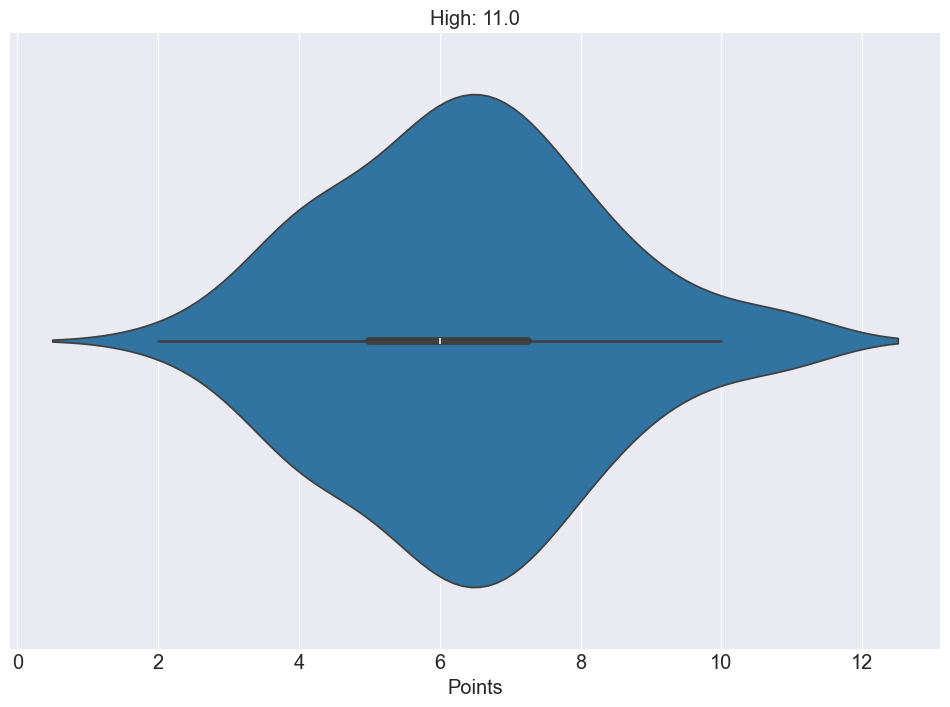

In [29]:
ax = sns.violinplot(x = results_df['Points'])

ax.set_title(f'High: {highscore}')